In [23]:
from matplotlib import pyplot as plt
import csv
import numpy as np
import os
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from skimage.filters import threshold_otsu
import sys

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
ms = 1e-3
us = 1e-6

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

sys.path.append("C:\\Networking Experiment\\artiq codes\\artiq-master\\repository\\qn_artiq_routines")
from fitting.run_modeling import get_release_recap_fit_result, release_recap_retention_at_t

## 2025

In [99]:
fnames = get_files_by_criteria(date_filters=["2025-06-02"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 2 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-06-02\08\000026465-GeneralVariableScan.h5) scanned over t_FORT_drop
skipped 1 redundant files
1 scan_variables over 1 variable scans


### release recapture experiment

experiment: atom_loading_2_experiment
override: {'dummy_variable':4,'t_microwave_pulse':2*us,'f_microwaves_dds':(334.684101+0.02)*MHz}
# of iterations:  50
iteration 30, no measurements


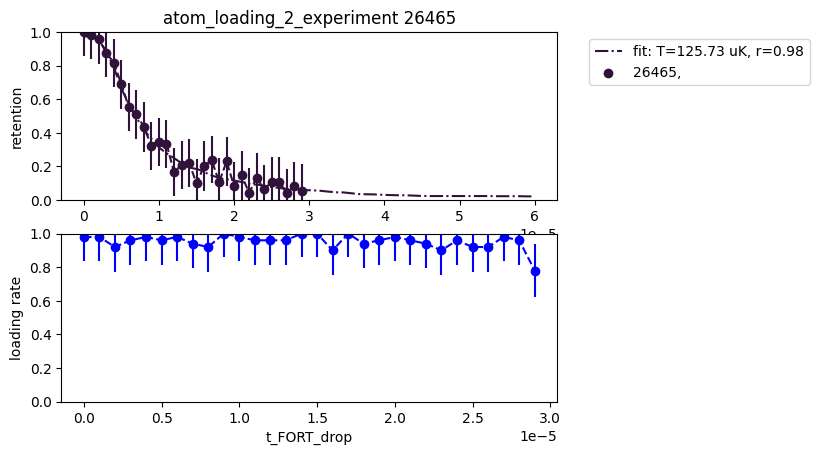

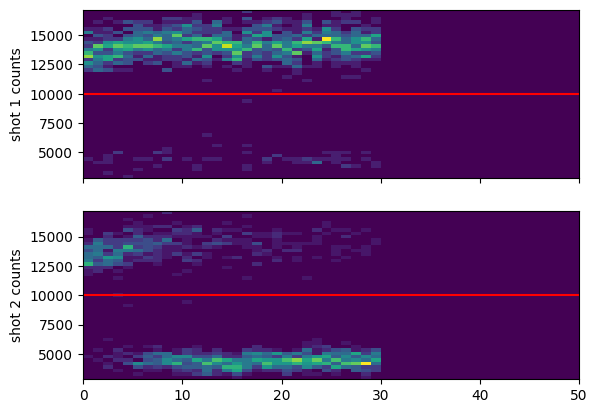

In [100]:
"""
I need to understand the details and check the analysis. Also has some bugs; if you get "ValueError: Residuals are not finite in the initial point",
reload the file and run the analysis again.

"""

### the file(s) to analyze:
file_indices = {
    0:''
    # 15: ''
    # 39:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False
fit_data = True

trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(SPCM0_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(SPCM0_RO1, SPCM0_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                                      for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 60, 60)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2025-03-05-7

In [10]:
fnames = get_files_by_criteria(date_filters=["2025-03-07"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 7 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-03-07\09\000022691-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-03-07\09\000022693-GeneralVariableScan.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-03-07\09\000022695-GeneralVariableScan.h5) scanned over dummy_variable
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-03-07\10\000022698-GeneralVariableScan.h5) scanned over t_FORT_drop
skipped 3 redundant files
2 scan_variables over 4 variable scans


### release recapture experiment

experiment: atom_loading_2_experiment
override: {'dummy_variable':4}
# of iterations:  11


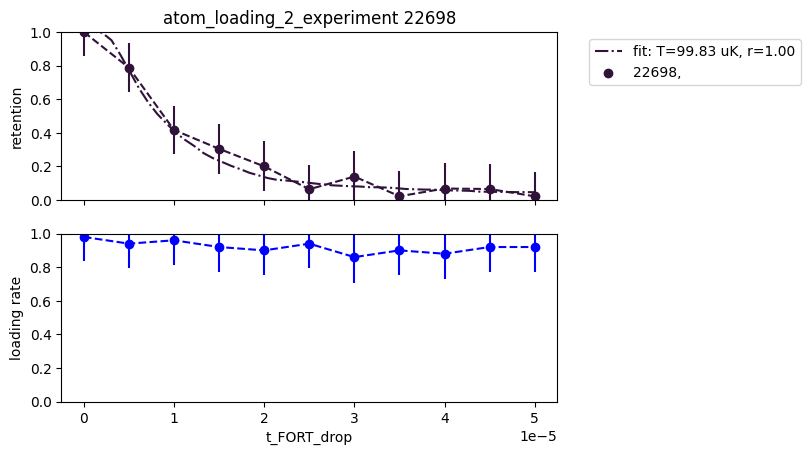

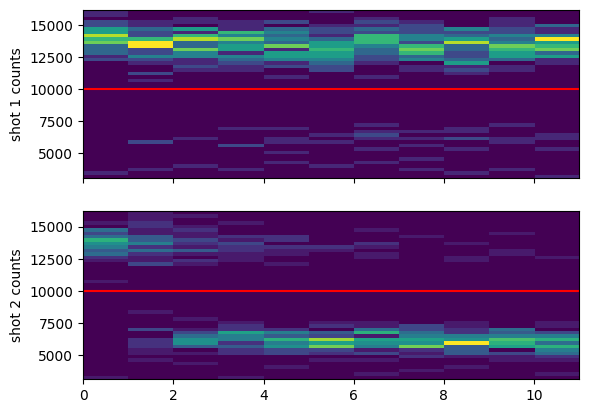

In [11]:
"""
I need to understand the details and check the analysis. Also has some bugs; if you get "ValueError: Residuals are not finite in the initial point",
reload the file and run the analysis again.

"""

### the file(s) to analyze:
file_indices = {
    5:''
    # 39:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False
fit_data = True

trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(SPCM0_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(SPCM0_RO1, SPCM0_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2])/t_SPCM_first_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                                      for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 50, 50)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,histMin,histMax])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.11.06

In [3]:
fnames = get_files_by_criteria(date_filters=["2024-11-06"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 43 files
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\12\000018956-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\13\000018958-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\13\000018959-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\13\000018960-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\13\000018962-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 13 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\14\000018967-GeneralVariableScan.h5) scanned over t_FORT_drop
file 15 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-06\14\000018969-GeneralVariableScan.h5) scanned 

### release recapture experiment

experiment: atom_loading_experiment
experiment: atom_loading_experiment


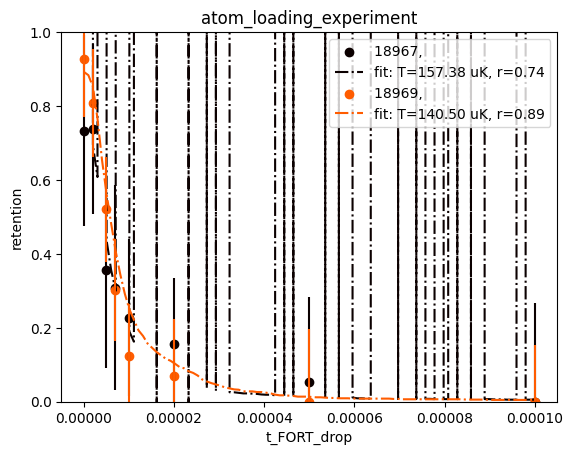

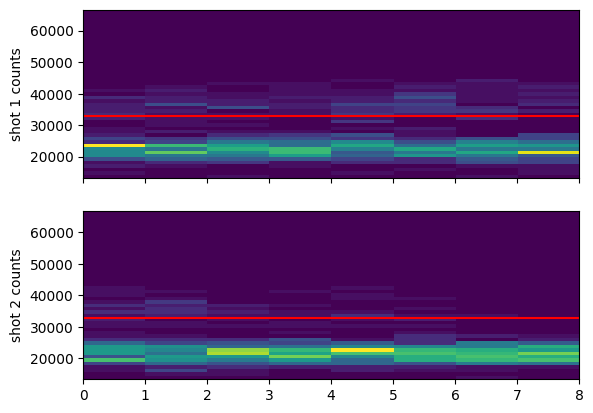

In [4]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    13: '',
    15: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [5]:
scan_sequence1

array([0.e+00, 2.e-06, 5.e-06, 7.e-06, 1.e-05, 2.e-05, 5.e-05, 1.e-04])

### 2024.09.27

In [5]:
fnames = get_files_by_criteria(date_filters=["2024-10-01"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 8 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-10-01\16\000017951-GeneralVariableScan.h5) scanned over t_delay_between_shots
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-10-01\16\000017952-GeneralVariableScan.h5) scanned over t_FORT_drop
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-10-01\17\000017953-GeneralVariableScan.h5) scanned over t_FORT_drop
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-10-01\17\000017954-GeneralVariableScan.h5) scanned over t_FORT_drop
skipped 4 redundant files
2 scan_variables over 4 variable scans


### release recapture experiment

experiment: atom_loading_experiment
experiment: atom_loading_experiment


ValueError: Residuals are not finite in the initial point.

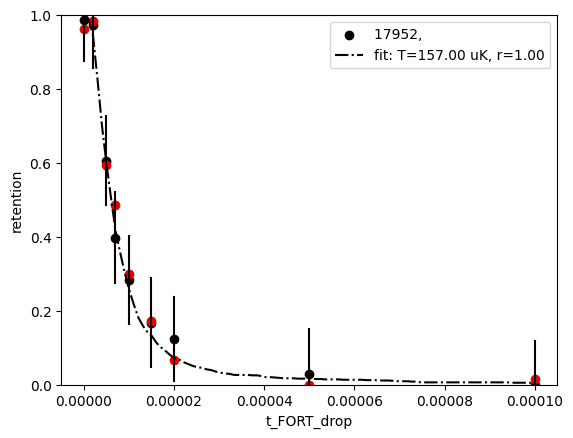

In [6]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    # 7: ''
    2: '',
    4: '',
    6: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [28]:
scan_sequence1

array([0.0e+00, 2.0e-06, 5.0e-06, 7.0e-06, 1.0e-05, 1.5e-05, 2.0e-05,
       5.0e-05, 1.0e-04])

### 2024.09.27

In [24]:
fnames = get_files_by_criteria(date_filters=["2024-09-27"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 9 files
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-27\12\000017876-GeneralVariableScan.h5) scanned over t_FORT_drop
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-27\13\000017877-GeneralVariableScan.h5) scanned over t_FORT_drop
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-27\13\000017878-GeneralVariableScan.h5) scanned over t_FORT_drop
skipped 4 redundant files
1 scan_variables over 3 variable scans


### release recapture experiment -2nd?

experiment: atom_loading_experiment


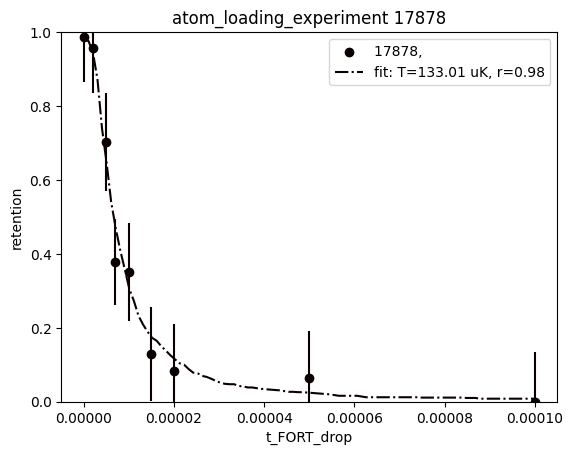

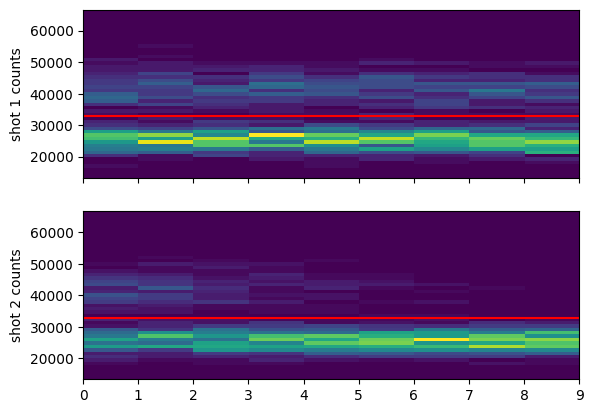

In [28]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    # 7: ''
    7: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [29]:
scan_sequence1

array([0.0e+00, 2.0e-06, 5.0e-06, 7.0e-06, 1.0e-05, 1.5e-05, 2.0e-05,
       5.0e-05, 1.0e-04])

### release recapture experiment

experiment: atom_loading_experiment


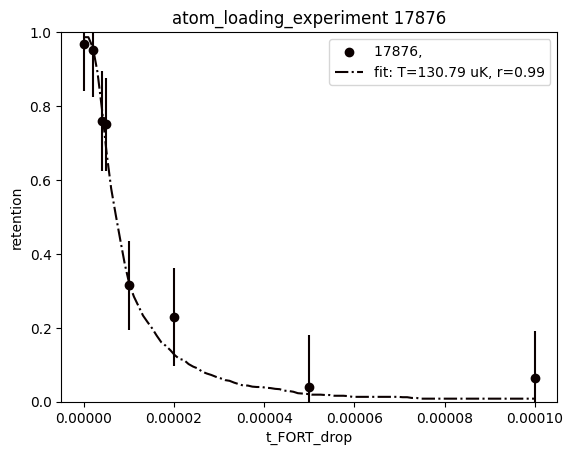

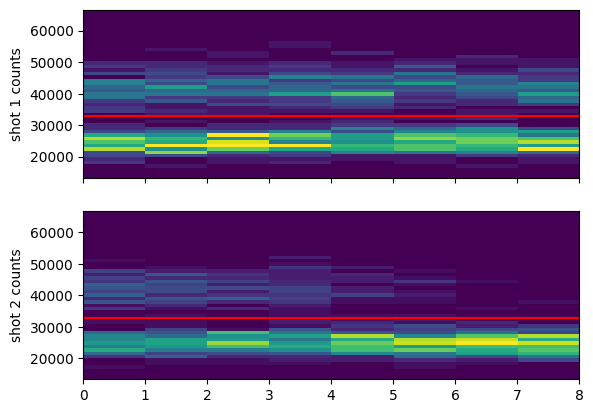

In [27]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    # 0: '', # after the ARTIQ hardware incident, realizing Sampler0 ch0 was bad and switching PD1 to ch7, and running M-LOOP again. -- accidentally used the wrong units; running again.
    3: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### 2024.09.23

In [11]:
fnames = get_files_by_criteria(date_filters=["2024-09-23"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 14 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\12\000017734-GeneralVariableScan.h5) scanned over t_FORT_drop
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\13\000017735-GeneralVariableScan.h5) scanned over t_FORT_drop
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\13\000017736-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\14\000017737-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\14\000017739-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\14\000017742-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 11 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-23\14\000017744-GeneralVariableScan.h5) scanned over du

### release recapture experiment

experiment: atom_loading_experiment


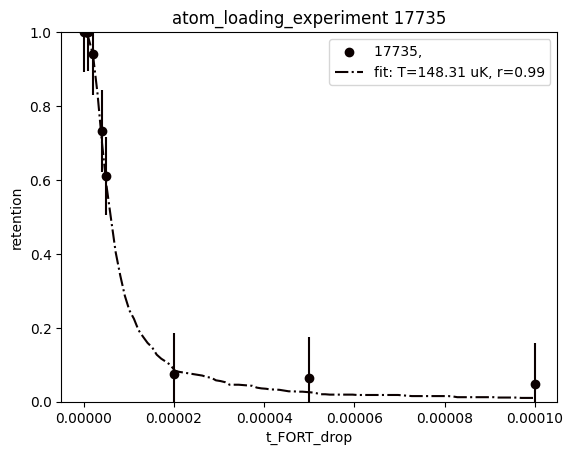

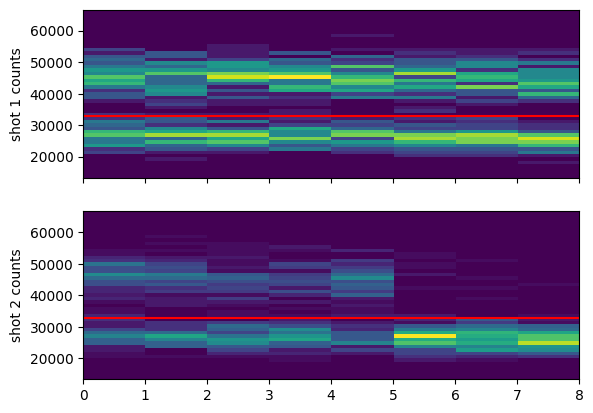

In [10]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    # 0: '', # after the ARTIQ hardware incident, realizing Sampler0 ch0 was bad and switching PD1 to ch7, and running M-LOOP again. -- accidentally used the wrong units; running again.
    2: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [7]:
retention

array([1.        , 0.98484848, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

### 2024.09.19

In [3]:
fnames = get_files_by_criteria(date_filters=["2024-09-19"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariable"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 15 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\10\000017576-GeneralVariableScan.h5) scanned over t_FORT_drop
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\10\000017577-GeneralVariableScan.h5) scanned over t_FORT_drop
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\10\000017578-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\10\000017579-GeneralVariableScan.h5) scanned over dummy_variable
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\11\000017580-GeneralVariableScan.h5) scanned over dummy_variable
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\11\000017581-GeneralVariableScan.h5) scanned over dummy_variable
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-19\11\000017582-GeneralVariableScan.h5) scanned over dummy_variab

### release recapture experiment

experiment: atom_loading_experiment
experiment: atom_loading_experiment


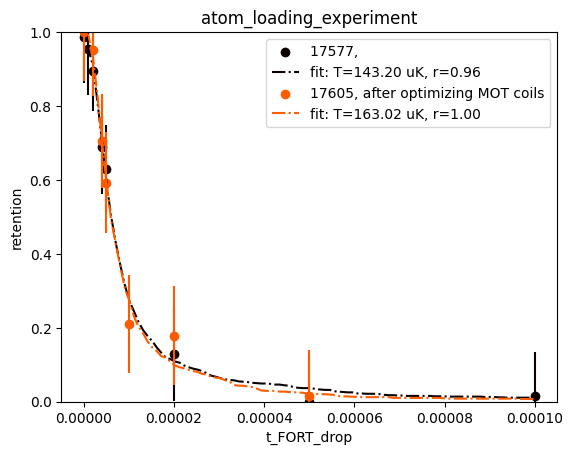

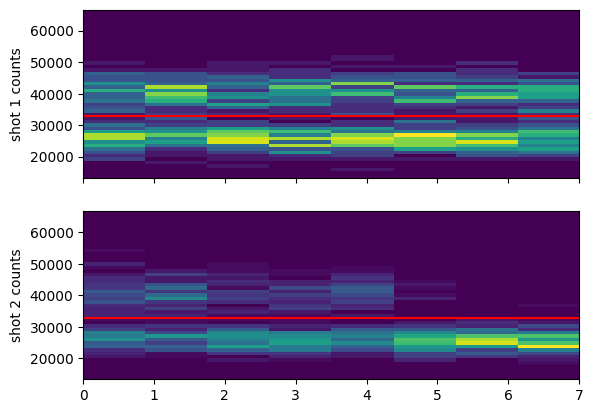

In [6]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    1: '',
    13: 'after optimizing MOT coils',
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [31]:
scan_sequence1

array([0.e+00, 2.e-06, 4.e-06, 5.e-06, 1.e-06, 2.e-05, 5.e-05, 1.e-04])

### release recapture experiment

experiment: atom_loading_experiment


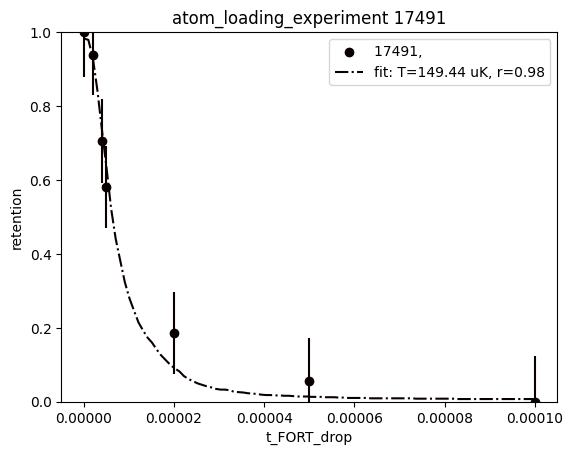

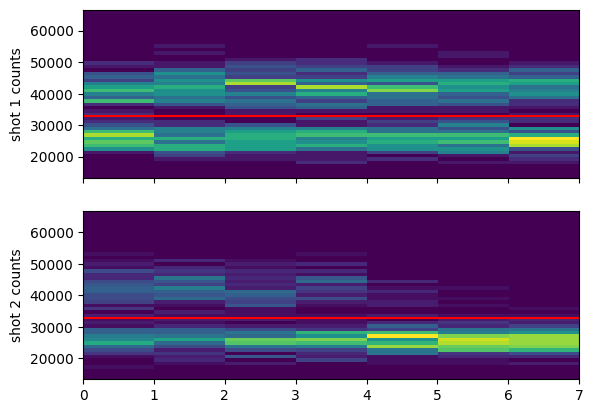

In [25]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    6: '',
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### 2024.09.13

In [9]:
fnames = get_files_by_criteria(date_filters=["2024-09-13"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\15\000017382-GeneralVariableScan_atom_loading_scan_over_t_FORT_drop.h5, which is corrupt
found 19 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\09\000017365-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\09\000017366-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\10\000017367-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\10\000017368-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\11\000017369-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-13\11\000017370-Gen

### release recapture experiment

experiment: atom_loading_experiment


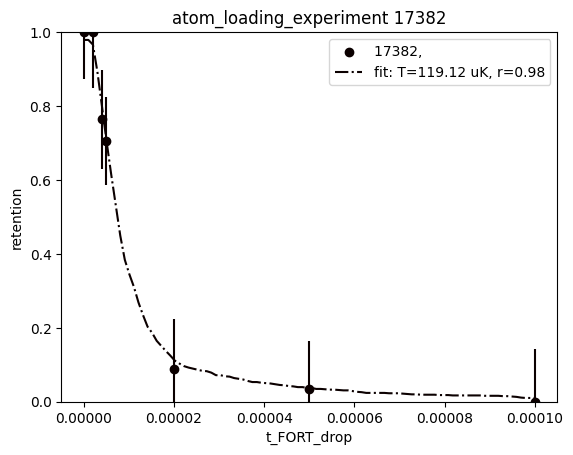

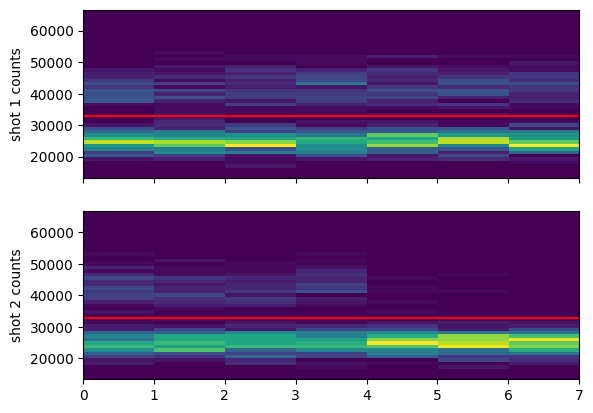

In [20]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2.1e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    # 14: '',
    # 16: '',
    18: '',
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [16]:
scan_sequence1

array([0.e+00, 2.e-06, 4.e-06, 5.e-06, 2.e-05, 5.e-05, 1.e-04])

In [5]:
get_release_recap_fit_result?

Signature:
get_release_recap_fit_result(
    tlist,
    retention,
    p0=None,
    bounds=None,
    retention_at_t_kwargs={},
)
Docstring:
:param tlist:
:param retention:
:param p0:
:param bounds: array of 2-tuple of boundaries for temp in K and retention with 1st (2nd) tuple minima (maxima)
:param retention_at_t_kwargs: keyword arguments for release_recap_retention_at_t which is used as the model
        for the fit. these arguments might specify, e.g., the trap parameters
:return: tuple of popt from curve_fit, y points from model evaluated with fit params
File:      c:\networking experiment\artiq codes\artiq-master\repository\qn_artiq_routines\fitting\run_modeling.py
Type:      function

### release recapture experiment

experiment: atom_loading_experiment


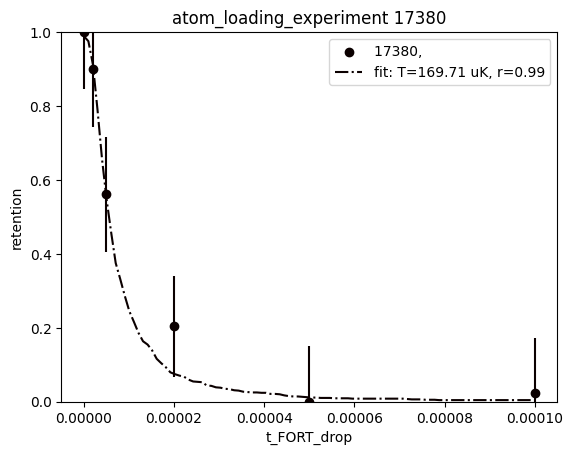

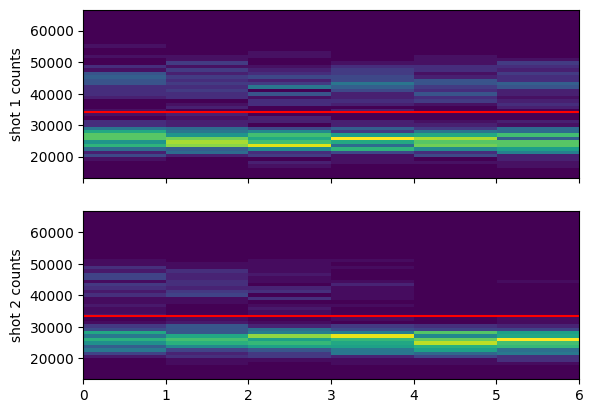

In [58]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    14: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    if otsu_threshold:
        cutoff1 = threshold_otsu(photocounts)
        cutoff2 = threshold_otsu(photocounts2)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,cutoff2=cutoff1)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### 2024.08.21
Yesterday we ran optimization scans to improve the temperature (retention after a FORT drop); check if it's any better today

In [53]:
fnames = get_files_by_criteria(date_filters=["2024-08-21"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = []

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 39 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\10\000016773-GeneralVariableScan.h5) scanned over t_FORT_drop
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\10\000016774-GeneralVariableScan.h5) scanned over t_FORT_drop
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\10\000016775-GeneralVariableScan.h5) scanned over t_FORT_drop
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\13\000016781-GeneralVariableScan.h5) scanned over dummy_variable
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\13\000016784-GeneralVariableScan.h5) scanned over f_microwaves_dds
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\14\000016785-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5) scanned over f_microwaves_dds
file 11 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-21\14\000016787-Gene

### release recapture experiment

experiment: atom_loading_experiment
experiment: atom_loading_experiment
experiment: atom_loading_experiment


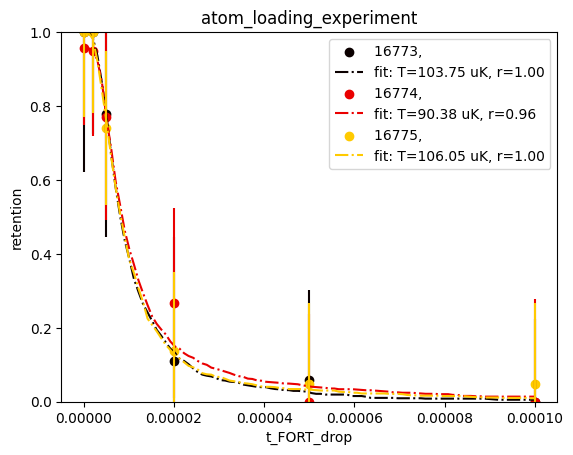

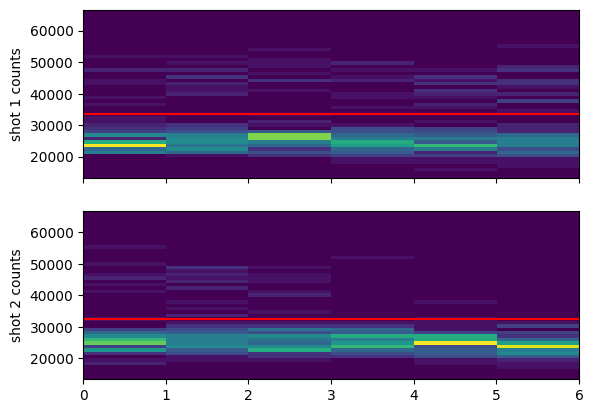

In [54]:
compare = True # compare multiple files in the same retention and loading plots
showhist = True
showloading = False
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
custom_xlabel = False
fit_data = True
trap_params = {'Tdepth': 2e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1
cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    0: '', 
    2: '',
    4: ''
} # the files to plot    

# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    if otsu_threshold:
        cutoff1 = threshold_otsu(photocounts)
        cutoff2 = threshold_otsu(photocounts2)

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,cutoff2=cutoff1)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [56]:
scan_sequence1

array([0.e+00, 2.e-06, 5.e-06, 2.e-05, 5.e-05, 1.e-04])

504


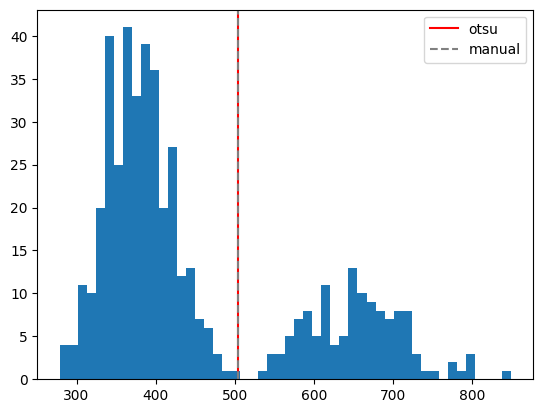

In [51]:
# check that we're using a good threshold by comparing it to the Otsu threshold
fig,ax = plt.subplots()
ax.hist(photocounts,bins=50)
otsu_cutoff = threshold_otsu(photocounts)
print(otsu_cutoff)
ax.axvline(otsu_cutoff,label='otsu',color='red')
ax.axvline(cutoff1,label='manual',color='grey',linestyle='--')
ax.legend()

### 2024.08.19

In [2]:
fnames = get_files_by_criteria(date_filters=["2024-08-19"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 14 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\14\000016582-GeneralVariableScan.h5) scanned over t_FORT_drop
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\14\000016583-GeneralVariableScan.h5) scanned over t_FORT_drop
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\15\000016584-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\16\000016585-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\17\000016588-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\17\000016628-GeneralVariableScan.h5) scanned over t_FORT_drop
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-08-19\17\000016632-GeneralVariableScan.h5) scanned over t_PGC_in_MOT
file 12

### release recapture experiment

experiment: atom_loading_experiment
experiment: atom_loading_experiment


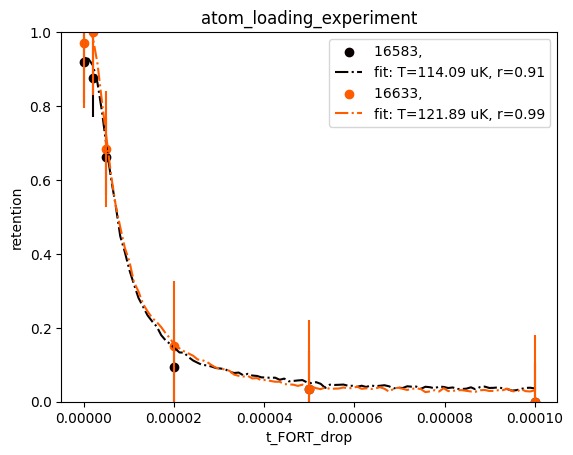

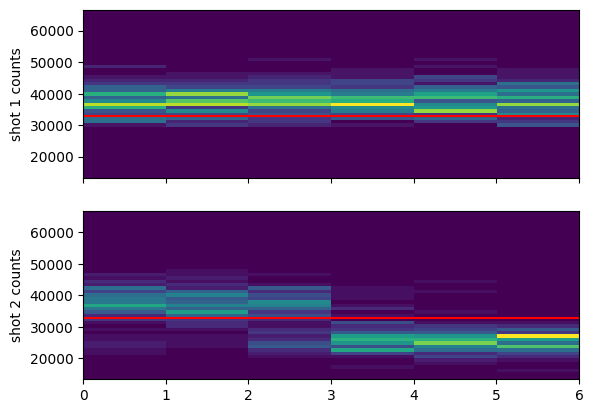

In [38]:
compare = True # compare multiple files in the same retention and loading plots

fit_data = True
trap_params = {'Tdepth': 2e-3, 'wx': 0.8e-6, 'lmda': 8.52e-7}
temp_guess_uK = 100e-6
baseline_retention_guess = 1

cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. we measure counts.

file_indices = {
    2: '', 
    12: '', 
} # the files to plot

custom_xlabel = False
# xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing

if custom_xlabel:
    # xsteps_xform = lambda x: 816.656 - 2*x - 92.65
    xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm MHz)$"
    xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz
else:
    xsteps_xform = lambda x: x # do nothing

showhist = True
showloading = False
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'uW detuning:{(f_microwaves_dds-f_dds_clock_resonance)*1e-3:.2f}kHz'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f't_microwave_pulse:{(t_microwave_pulse)*1e6:.2f} us'
# f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''f'blowaway light {"off" if blowaway_light_off else "on"}'

loc=(1.05,-0.05)
loc='lower left' 
loc='upper right'
loc='best'

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    # cutoff1=cutoff2 = 31000*t_SPCM_first_shot

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,cutoff2=cutoff1)

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     shot1 = photocounts[i*n_measurements:(i+1)*n_measurements]
        #     shot2 = photocounts2[i*n_measurements:(i+1)*n_measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # # fig.tight_layout()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        xsteps = xsteps_xform(scan_sequence1)[loading > 0]
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        if not fit_data:
            ax_ret.plot(xsteps, retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps, retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))

        if fit_data:
            t_steps_us = scan_sequence1[loading > 0]*1e6
            popt, fit_retention = get_release_recap_fit_result(t_steps_us, retention[loading > 0], p0=[temp_guess_uK,baseline_retention_guess], retention_at_t_kwargs=trap_params)

            try: # I haven't figured out why this is the case, but release recap only returns the correct result after being run twice... wtf
                hi_res_t_steps_us = np.linspace(0, 100, 100)
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)
                assert np.amin(fit_retention) > 0
            except:
                fit_retention = release_recap_retention_at_t(hi_res_t_steps_us, T=popt[0], base_retention=popt[1], **trap_params)

            ax_ret.plot(xsteps_xform(hi_res_t_steps_us*1e-6), fit_retention, label=f'fit: T={popt[0]*1e6:.2f} uK, r={popt[1]:.2f}', color=ret_cmap(idx/len(file_indices)), linestyle='dashdot')

        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps, retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps, loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps, loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps, loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

492


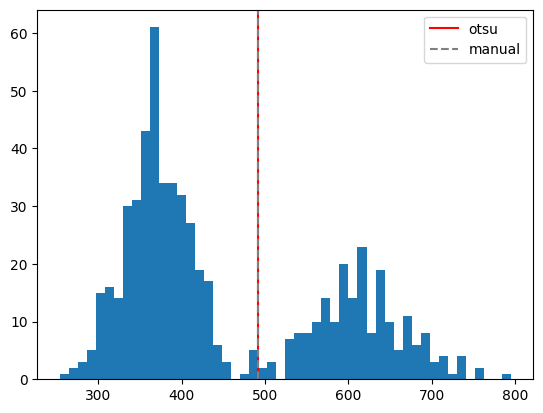

In [40]:
# check that we're using a good threshold by comparing it to the Otsu threshold
fig,ax = plt.subplots()
ax.hist(photocounts,bins=50)
otsu_cutoff = threshold_otsu(photocounts)
print(otsu_cutoff)
ax.axvline(otsu_cutoff,label='otsu',color='red')
ax.axvline(cutoff1,label='manual',color='grey',linestyle='--')
ax.legend()

In [ ]:
# this is the first experiment to measure the temperature of our single atoms in the dipole trap

f = h5py.File(os.path.join(results, "2024-08-19\\14\\000016583-GeneralVariableScan_atom_loading_scan_over_t_FORT_drop.h5"))
[x for x in f['datasets']]

In [13]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = np.array([0.0, 2.0, 5.0, 20.0, 50.0, 100.])*us

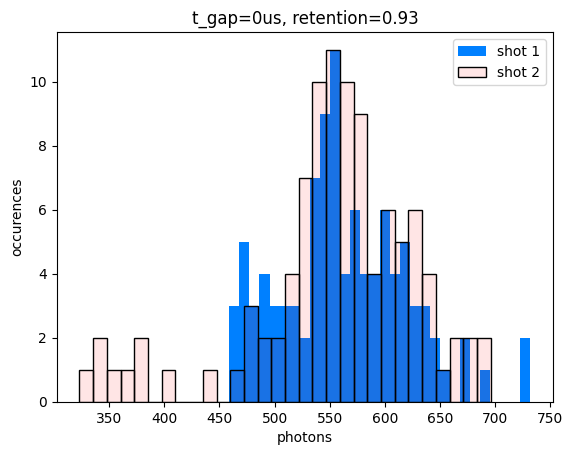

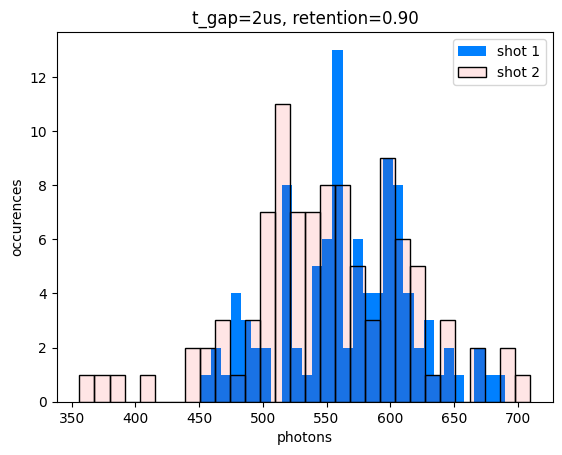

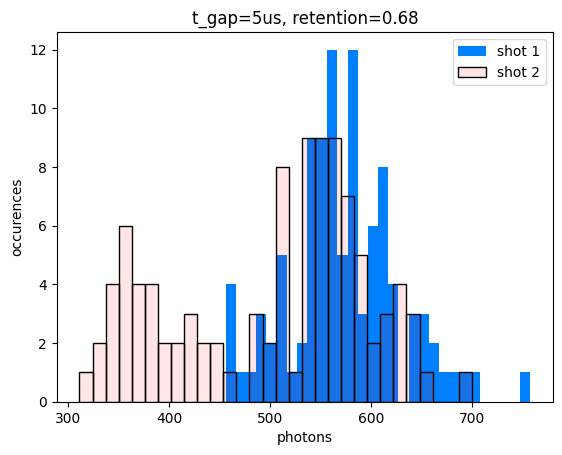

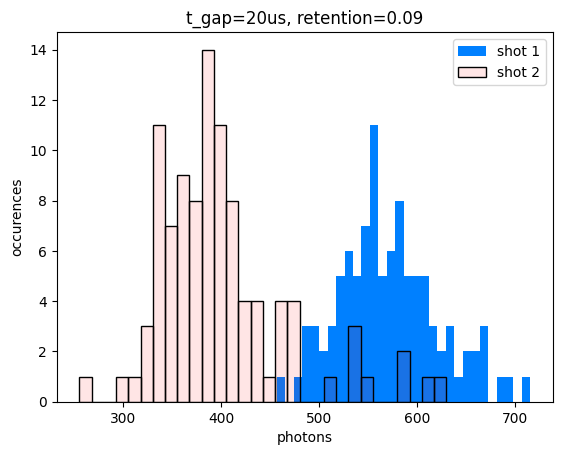

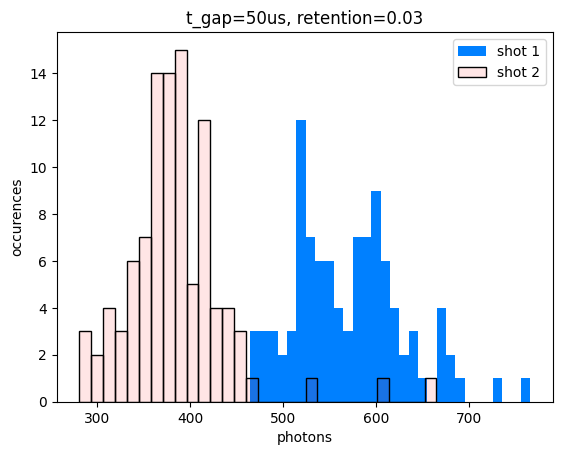

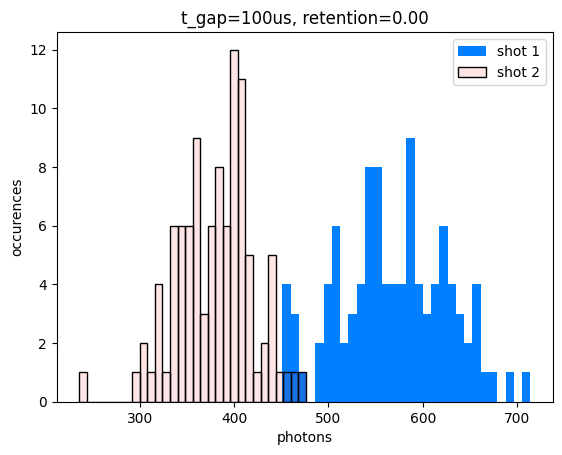

In [18]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
#cutoff = [210]*4
cutoff = [480]*6

retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    
    plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

# for i,t in enumerate(t_delay_arr):
#     shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
#     shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
#     plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
#     plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
#     plt.title(f"t={t/us:.0f}us")
#     plt.show()
#     atoms_loaded = [x > cutoff[i] for x in shot1]
#     n_atoms_loaded = sum(atoms_loaded)
#     atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
#     retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
#     retention_array[i] = retention_fraction
#     loading_rate_array[i] = n_atoms_loaded/n_measurements


Text(0.5, 0, 't (us)')

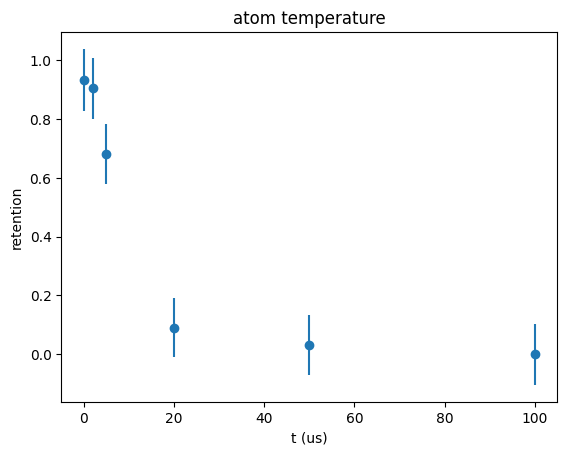

In [30]:
# plt.scatter(t_delay_arr/us, retention_array/retention_array[0])
# t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
# tau = 1.75
# plt.title('atom temperature')
# # plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
# plt.ylabel("retention (normalized)")
# plt.xlabel("t (us)")
# # plt.xlim((0,1.1))
# # plt.legend()

plt.scatter(t_delay_arr/us, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
plt.title('atom temperature')
plt.errorbar(t_delay_arr/us,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (us)")
# plt.xlim((0,1.1))
# plt.legend()

In [20]:
n_atoms_loaded_array

array([90., 94., 94., 99., 95., 92.])

In [21]:
retention_array

array([0.93333333, 0.90425532, 0.68085106, 0.09090909, 0.03157895,
       0.        ])

Text(0.5, 0, 'minutes')

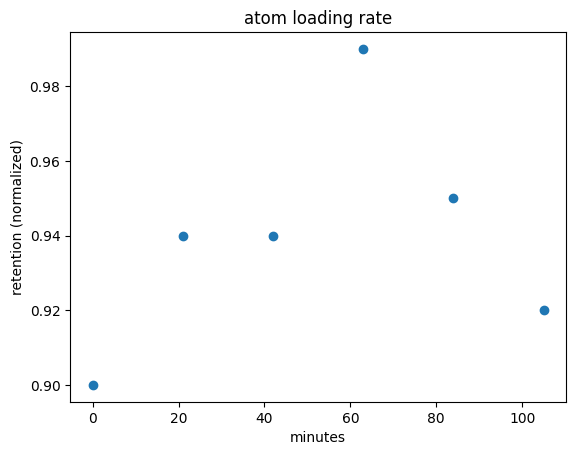

In [23]:
time = np.linspace(0,60+45,6)
plt.scatter(time,loading_rate_array)
plt.title('atom loading rate')
# plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("minutes")

## November 2023

### 2023.11.20

In [2]:
# this is the first experiment to measure the temperature of our single atoms in the dipole trap

f = h5py.File(os.path.join(results, "2023-11-20\\11\\000007872-SingleAtomTemperature.h5"))
[x for x in f['datasets']]

['AOM_A1_power',
 'AOM_A2_power',
 'AOM_A3_power',
 'AOM_A4_power',
 'AOM_A5_power',
 'AOM_A6_power',
 'FORT_monitor',
 'MOT1_monitor',
 'MOT2_monitor',
 'MOT3_monitor',
 'MOT4_monitor',
 'MOT5_monitor',
 'MOT6_monitor',
 'MOT_switchyard_monitor',
 'atom_counts_threshold',
 'atom_retention',
 'bins',
 'do_PGC_in_MOT',
 'n_measurements',
 'no_first_shot',
 'p_cooling_DP_MOT',
 'photocount_bins',
 'photocounts',
 'photocounts2',
 'scan_datasets',
 't_delay_between_shots']

In [6]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = np.array([1.0, 10.0, 50.0, 100.])*us

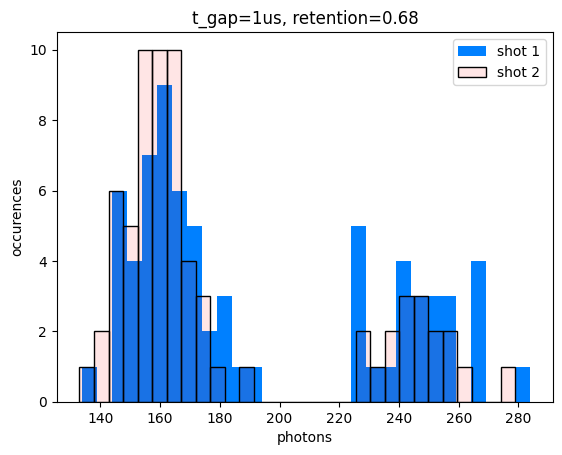

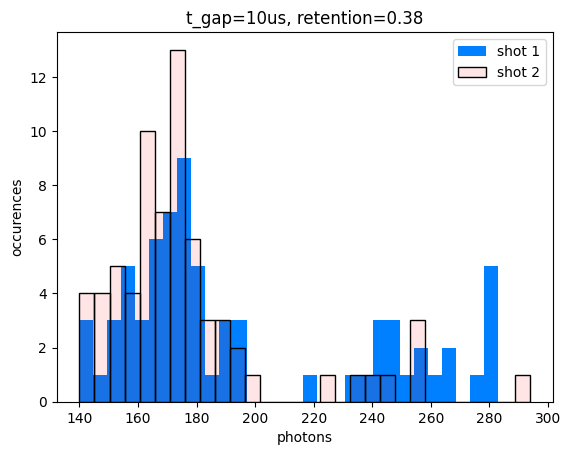

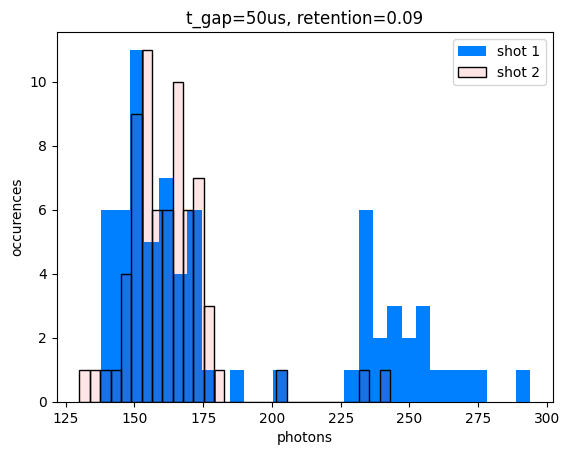

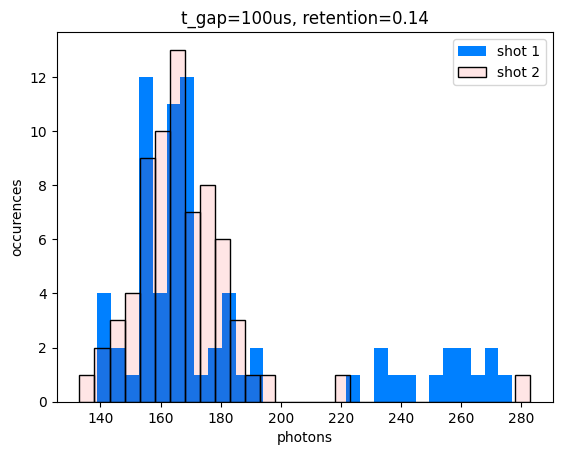

In [17]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [210]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))

n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    plt.title(f"t_gap={t/us:.0f}us, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

# for i,t in enumerate(t_delay_arr):
#     shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
#     shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
#     plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
#     plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
#     plt.title(f"t={t/us:.0f}us")
#     plt.show()
#     atoms_loaded = [x > cutoff[i] for x in shot1]
#     n_atoms_loaded = sum(atoms_loaded)
#     atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
#     retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
#     retention_array[i] = retention_fraction
#     loading_rate_array[i] = n_atoms_loaded/n_measurements

Text(0.5, 0, 't (s)')

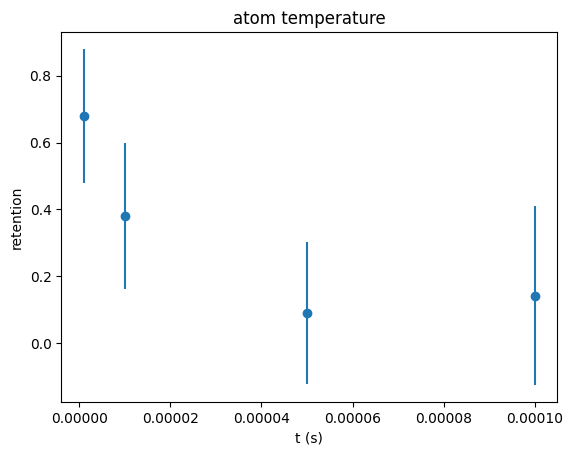

In [26]:
# plt.scatter(t_delay_arr/us, retention_array/retention_array[0])
# t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
# tau = 1.75
# plt.title('atom temperature')
# # plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
# plt.ylabel("retention (normalized)")
# plt.xlabel("t (us)")
# # plt.xlim((0,1.1))
# # plt.legend()

plt.scatter(t_delay_arr, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
plt.title('atom temperature')
plt.errorbar(t_delay_arr,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
# plt.legend()

In [23]:
n_atoms_loaded_array

array([25., 21., 22., 14.])

In [15]:
retention_array

array([0.68      , 0.38095238, 0.09090909, 0.14285714])

Text(0.5, 0, 'minutes')

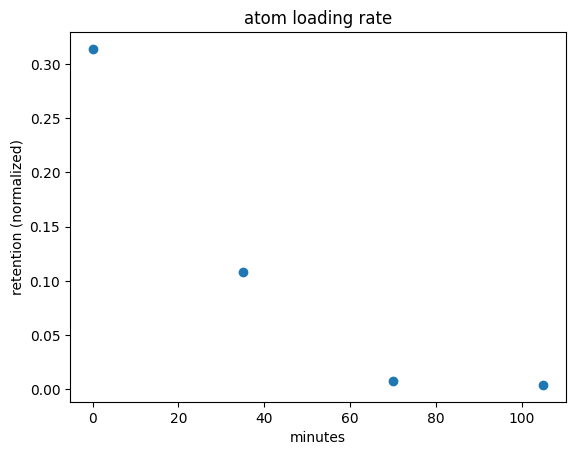

In [103]:
time = np.linspace(0,60+45,4)
plt.scatter(time,loading_rate_array)
plt.title('atom loading rate')
# plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("minutes")

In [ ]:
19

In [ ]:
plt.plot()

In [ ]:
# t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
# photocounts = np.array(f['datasets']['photocounts'])[1:]
# measurements = np.uint(f['datasets']['n_measurements'])
# t_FORT_loading_list.append(t_FORT_loading)
# photocounts_list.append(photocounts)

# threshold = 260
# atoms = len(photocounts[photocounts>threshold])
# r_loading = atoms/len(photocounts)
# plt.hist(photocounts, bins=bins)#,alpha=0.5)
# plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
# plt.xlabel("photons")
# plt.ylabel("occurrences")
# # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
# plt.show()

In [24]:
ids = ['2023-10-23\\09\\000006656','2023-10-23\\09\\000006661','2023-10-23\\10\\000006663']
t_FORT_loading_list = []
photocounts_list = []
for id in ids:
    f = h5py.File(os.path.join(results, f'{id}-SimpleAtomTrapNoChop.h5'))
    # [x for x in f['datasets'].values()]
    t_FORT_loading = np.single(f['archive']['t_FORT_loading'])
    photocounts = np.array(f['datasets']['photocounts'])[1:]
    measurements = np.uint(f['datasets']['n_measurements'])
    t_FORT_loading_list.append(t_FORT_loading)
    photocounts_list.append(photocounts)

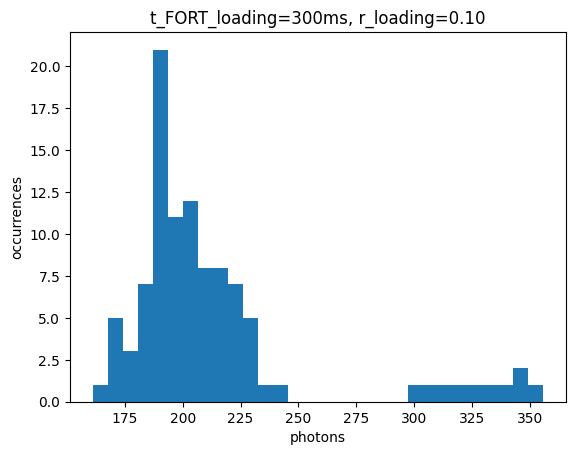

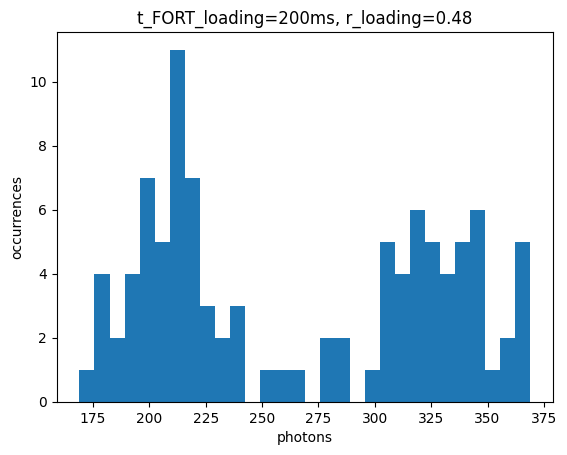

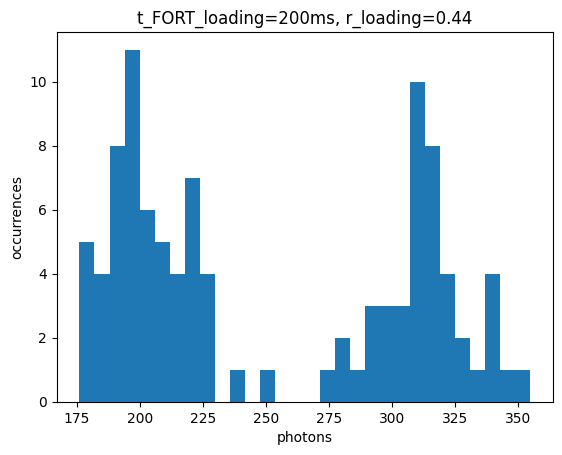

In [26]:
bins = 30
threshold = 270
for t_FORT_loading,photocounts in zip(t_FORT_loading_list,photocounts_list):
    atoms = len(photocounts[photocounts>threshold])
    r_loading = atoms/len(photocounts)
    plt.hist(photocounts, bins=bins)#,alpha=0.5)
    plt.title(f't_FORT_loading={t_FORT_loading/0.001:.0f}ms, r_loading={r_loading:.2f}')
    plt.xlabel("photons")
    plt.ylabel("occurrences")
    # plt.savefig(f'atom_loading_20231012_{bins}_bins.pdf')
    plt.show()

In [9]:
ax.hist?